#  Analyzing the Interplay Between Meteorological Factors and Urban Air Quality

Author: Boyu Ren

Course Project, UC Irvine, Math 10, F23

## Introduction

In this data analysis project, we delve into the intricate relationship between air quality and meteorological conditions. The core claim of this investigation is to ascertain the impact that weather factors such as temperature have on the concentration of air pollutants, with a specific focus on nitrogen oxides (NOx), which are key indicators of air pollution and have significant implications for environmental health and public policy. The importance of understanding this relationship cannot be overstated. With increasing awareness of climate change and its impact on urban living, this analysis could be pivotal for city planners, environmentalists, and health professionals who seek to design effective interventions to improve air quality.

## Main Part

### Import packages and data

In [ ]:
import pandas as pd
import altair as alt
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression
from pandas.api.types import is_numeric_dtype
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

### Check the dataset's shape, understand data types for each column, identify missing values

In [ ]:
air_quality_data = pd.read_csv('AirQualityUCI.csv',delimiter=';')

# Inspect the first few rows and the general information of the dataset
air_quality_data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [ ]:
air_quality_data.info

<bound method DataFrame.info of             Date      Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  \
0     10/03/2004  18.00.00    2,6       1360.0     150.0     11,9   
1     10/03/2004  19.00.00      2       1292.0     112.0      9,4   
2     10/03/2004  20.00.00    2,2       1402.0      88.0      9,0   
3     10/03/2004  21.00.00    2,2       1376.0      80.0      9,2   
4     10/03/2004  22.00.00    1,6       1272.0      51.0      6,5   
...          ...       ...    ...          ...       ...      ...   
9466         NaN       NaN    NaN          NaN       NaN      NaN   
9467         NaN       NaN    NaN          NaN       NaN      NaN   
9468         NaN       NaN    NaN          NaN       NaN      NaN   
9469         NaN       NaN    NaN          NaN       NaN      NaN   
9470         NaN       NaN    NaN          NaN       NaN      NaN   

      PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
0            1046.0    166.0        1056.0    113.0        1692.0   
1

It provides concise summary of the DataFrame, including the data types of each column and helpful in identifying missing values and understanding the kind of data each column holds.

Now, after checking the given info of the data, I dicided to remove unnecessary columns. And here is a chatGPT suggestion that converting columns with comma as decimal separator to float, which will help me easier to handle data in later analysis. After that, I noticed time and data are seprate, which is not good to track for some visualization operations. So,I combined date and time into a single datetime column


In [ ]:
air_quality_data_cleaned = air_quality_data.drop(columns=['Unnamed: 15', 'Unnamed: 16'])

cols_to_convert = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
for col in cols_to_convert:
    air_quality_data_cleaned[col] = air_quality_data_cleaned[col].str.replace(',', '.').astype(float)

air_quality_data_cleaned['DateTime'] = pd.to_datetime(air_quality_data_cleaned['Date'] + ' ' + air_quality_data_cleaned['Time'], format='%d/%m/%Y %H.%M.%S')
air_quality_data_cleaned = air_quality_data_cleaned.drop(columns=['Date', 'Time'])

air_quality_data_cleaned.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00


In [ ]:
air_quality_data_cleaned.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


Count: There are 9357 observations for each variable.
Mean and Standard Deviation: These values give us an idea of the central tendency and dispersion for each variable.

We observe that the minimum value for several variables is -200, which could indicate missing or placeholder values. For simplicity, we'll drop rows with missing values. 

In [ ]:
key_variables = [air_quality_data_cleaned.columns]
air_quality_data_filtered = air_quality_data_cleaned

for var in key_variables:
    air_quality_data_filtered = air_quality_data_filtered[air_quality_data_filtered[var] != -200]

In [ ]:
air_quality_data_filtered=air_quality_data_filtered.dropna()
air_quality_data_filtered.shape

(827, 14)

Now, data is clean and appropriate for futher approaches.

In [ ]:
alt.data_transformers.disable_max_rows()

alt.Chart(air_quality_data_filtered).mark_bar().encode(
    alt.X('NOx(GT)', bin=True),
    alt.Y('count()'),
    tooltip=['NOx(GT)', 'count()']
).properties(
    title='Histogram of NOx Levels'
)


alt.Chart(...)

It appears that most of the NOx concentration values are clustered within lower range bins, suggesting that high NOx levels are less common. The shape of the histogram, which skews towards the lower end, indicates that extreme high values of NOx are outliers or occur infrequently.

In [ ]:
alt.Chart(air_quality_data_filtered).mark_boxplot().encode(
    alt.X('T'),
    tooltip=['T']
).properties(
    title='Boxplot of Temperature'
)

alt.Chart(...)

Boxplot indicates that most temperature values fall within a relatively narrow interval

In [ ]:
base = alt.Chart(air_quality_data_filtered).encode(
    alt.X('DateTime:T')
)

line_NOx = base.mark_line(color='blue').encode(
    alt.Y('NOx(GT)'),
    tooltip=['DateTime:T', 'NOx(GT)']
)

line_Temp = base.mark_line(color='red').encode(
    alt.Y('T'),
    tooltip=['DateTime:T', 'T']
)

chart = alt.layer(line_NOx, line_Temp).resolve_scale(
    y='independent'
).properties(
    title='Time Series of NOx Levels and Temperature'
)
chart

alt.LayerChart(...)

The time series plot shows the fluctuations of NOx levels and temperature over time. We observe that NOx levels have considerable variability, with several peaks, which indicates high pollution. There seems to be no immediate, clear correlation between temperature and NOx levels visually from this plot. But, NOx levels variations seem to have some form of a cyclical pattern which does not appear to be directly mirrored by temperature.

Now, let's do regression analysis to do futher research about it.

In [ ]:
X = air_quality_data_filtered[['T']]
y = air_quality_data_filtered['NOx(GT)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)

Mean Absolute Error: 61.246507897236604
Mean Squared Error: 6017.096172269701


In [ ]:
scatter_plot = alt.Chart(air_quality_data_filtered).mark_circle().encode(
    x='T',
    y='NOx(GT)',
    tooltip=['T', 'NOx(GT)']
)

regression_line = scatter_plot.transform_regression('T', 'NOx(GT)').mark_line()

scatter_plot + regression_line

alt.LayerChart(...)

Here we have a scatter plot along with a regression line. The data points are widely scattered, but the upward trend of the regression line suggests that higher temperatures are generally associated with higher NOx levels. Nonetheless, the broad spread of the points around the line indicates that temperature alone does not predict NOx levels with high precision, and other factors are also at play.

Because we can see from the figure that the data is not well correlated, the model does not learn and perform well, either in the train data or the test data. Also, from the results, model is underfitting. Underfitting occurs when a model is too simple to capture the underlying patterns in the data, and as a result, it may perform poorly on both the training and testing datasets.

One indicator in a weather system may receive the influence of multiple variables. There is not just a single relationship between them.

I want to understand more about the relationship between their key indicators. Correlation Matrix Heatmap is a good and clear choice to understand their relationship.

In [ ]:
correlation_matrix = air_quality_data_filtered[['T', 'RH', 'AH', 'NOx(GT)', 'CO(GT)', 'NO2(GT)', 'C6H6(GT)']].corr()
correlation_matrix

,T,RH,AH,NOx(GT),CO(GT),NO2(GT),C6H6(GT)
T,1.000000,-0.769869,0.159964,0.238395,0.318261,0.406807,0.418409
RH,-0.769869,1.000000,0.475776,-0.041975,-0.105157,-0.223033,-0.178410
AH,0.159964,0.475776,1.000000,0.270679,0.295591,0.214559,0.313415
NOx(GT),0.238395,-0.041975,0.270679,1.000000,0.951342,0.857425,0.927304
CO(GT),0.318261,-0.105157,0.295591,0.951342,1.000000,0.861432,0.972660
NO2(GT),0.406807,-0.223033,0.214559,0.857425,0.861432,1.000000,0.846743
C6H6(GT),0.418409,-0.178410,0.313415,0.927304,0.972660,0.846743,1.000000


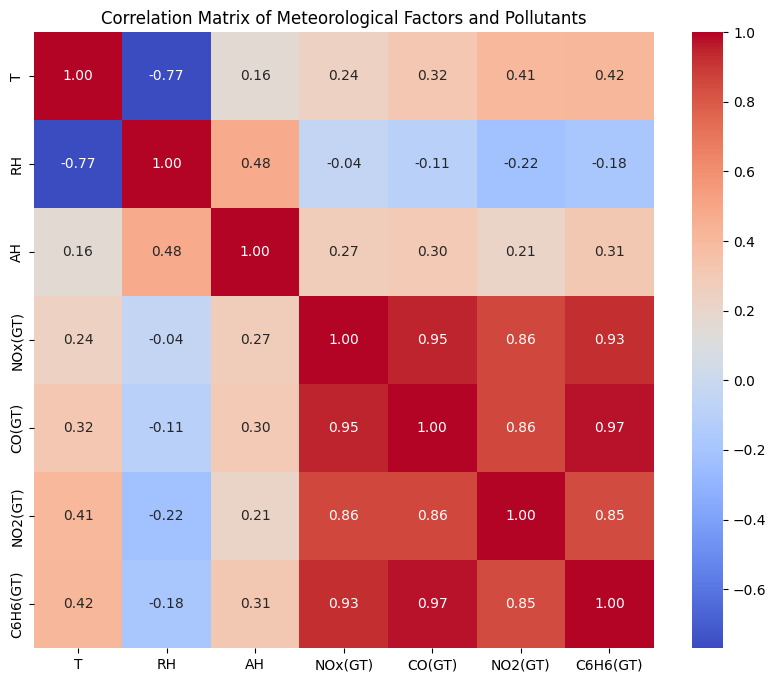

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Meteorological Factors and Pollutants')
plt.show()

The heat map visualizes the correlation coefficients between various meteorological factors and pollutants. A darker red color indicates a stronger positive correlation and a darker blue color indicates a stronger negative correlation. The strong positive correlation between different pollutants (e.g. NOx, CO, NO2 and C6H6) indicates that when the level of one pollutant is high, the level of other pollutants tends to be high as well.

When we check the correlation coefficients between NOx levels and temperature, 0.24 indicates our previous conclusion that higher temperatures are generally associated with higher NOx levels is true.

## Summary

Structure Summary: My research began with the importing of analytical libraries and the dataset, which was followed by a preliminary data review. The data was then painstakingly cleaned, with extraneous columns removed, data types normalized, and rows with missing values excluded. Following exploratory data analysis, histograms and boxplots provided visual insights into the distribution of contaminants and weather parameters. A thorough time series analysis revealed temporal trends as well as potential cyclical patterns. Inter-variable correlations were shown using correlation matrices, and the impact of climatic conditions on NOx levels was assessed using regression models. For a more interactive evaluation of the findings, interactive visualizations were constructed.

Analysis Summary: The analysis discovered fluctuating NOx levels and a possible positive association with temperature, implying that greater temperatures may be related with higher pollution levels. The correlation heatmap indicated significant interdependence among contaminants, pointing to shared sources of pollution. The regression model revealed that temperature is not the only predictor of NOx, highlighting the complexities of air quality concerns. The interactive plots highlighted the dynamic nature of air pollution, emphasizing the significance of taking into account several elements for successful air quality management.

## References

Your code above should include references.  Here is some additional space for references.

* What is the source of your dataset(s)?

From UC Irvine Machine Learning Repository:
https://archive.ics.uci.edu/dataset/360/air+quality

* List any other references that you found helpful.

I asked chatgpt for some help and I already mentioned them before I quoted for converting data types from strings to numeric values, particularly for columns that contained numeric values with commas as decimal separators.

I use the more complex correlation heatmap learned from https://www.geeksforgeeks.org/how-to-create-a-seaborn-correlation-heatmap-in-python/